In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from triqs.plot.mpl_interface import plt
from triqs.gf import Idx
from triqs_tprf.plotting_tools import bsplot

def plot_delta(delta, lamb):
    fig, axs = plt.subplots(figsize=(8, 5), ncols=2)

    nw = delta.data.shape[0]
    axs[0].plot(range(-nw//2, nw//2), delta[:, :].data[:,500, 0, 0].real *1e3)

    axs[0].set_xlabel(r"$i\nu_n$")
    axs[0].set_ylabel(r"$\Delta$ (meV)")


    im = axs[1].imshow(delta[Idx(0), :].data.reshape(nk, nk).real, cmap="RdBu")
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    axs[1].spines['top'].set_visible(True)
    axs[1].spines['right'].set_visible(True)

    axs[1].set_xlabel("$k_x$")
    axs[1].set_ylabel("$k_y$")

    axs[1].text(16, 16, "$\Gamma$", size=20)
    axs[1].text(32, 0, "$M$", size=20)
    axs[1].text(32, 16, "$X$", size=20)
    
    fig.suptitle(r"$\lambda = %.3f$" % lamb, fontsize=20)
    

def plot_chi(chi_m_wk, chi_d_wk):
    path = [(r'$\Gamma$', 2*np.pi*np.array([0.0, 0.0, 0.0])), 
            ('X', 2*np.pi*np.array([0.5, 0.0, 0.0])),
            ('M', 2*np.pi*np.array([0.5, 0.5, 0.0])), 
            (r'$\Gamma$', 2*np.pi*np.array([0.0, 0.0, 0.0])), 
           ]


    ax_bs = plt.subplot(111)

    ax_bs.bsplot(chi_m_wk[(Idx(0), slice(None))], path)
    ax_bs.bsplot(chi_d_wk[(Idx(0), slice(None))], path)

    ax_bs.set_ylabel(r'$\chi(i\nu_n=0, \mathbf{k})$', rotation=0, ha='right')
    ax_bs.text(0.62, 0.6, "$\chi^{m}$", transform = ax_bs.transAxes, size=22, color='C0')
    ax_bs.text(0.55, 0.18, "$\chi^{d}$", transform = ax_bs.transAxes, size=22, color='C1')

Starting run with 1 MPI rank(s) at : 2021-01-21 16:24:22.474799


In [2]:
plt.style.use('notebook.mplstyle')

# Solving the linearized Eliashberg equation in the random phase approximation limit

In this notebook we will walk you through the steps of solving the linearized Eliashberg equation in the random phase approximation (RPA) limit. Make sure, that you have read the [theory](https://triqs.github.io/tprf/latest/theory/eliashberg.html) before reading further.

The steps are
 1. Construct the density- and magnetic-susceptibilties in RPA
 2. Construct the particle-particle vertex in RPA
 3. Construct the symmetrizing functions
 4. Solve the linearized Eliashberg equation



## 1. Construct the density- and magnetic-susceptibilties in RPA

First we need a model and in this example we use the 1-band square lattice.

In [3]:
from triqs_tprf.tight_binding import create_square_lattice

square_lattice = create_square_lattice(norb=1, t=1.0)

Next we need the non-interacting one-particle Green's function. For this we first create the dispersion relation on a mesh on the Brillouin zone.

In [4]:
nk = 32

e_k = square_lattice.on_mesh_brillouin_zone((nk, nk, 1))

And then we solve the lattice dyson equation `lattice_dyson_g0_wk` for a specific fermionic Matsubara frequency mesh `MeshImFreq` to obtain the non-interacting one-particle Green's function `g0_wk`.

In [5]:
from triqs.gf import MeshImFreq
from triqs_tprf.lattice import lattice_dyson_g0_wk

wmesh = MeshImFreq(beta=10, S='Fermion', n_max=100)
g0_wk = lattice_dyson_g0_wk(mu=0, e_k=e_k, mesh=wmesh)

Next we solve for the density- and magnetic-susceptibilties in RPA by first constructing the bare bubble $\chi_0$ `imtime_bubble_chi0_wk`

In [6]:
from triqs_tprf.lattice_utils import imtime_bubble_chi0_wk

chi0_wk = imtime_bubble_chi0_wk(g0_wk, nw=100)


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌┬┐┌─┐┬─┐┌─┐
 ║ ╠╦╝║║═╬╗╚═╗   │ ├─┘├┬┘├┤ 
 ╩ ╩╚═╩╚═╝╚╚═╝   ┴ ┴  ┴└─└  
Two-Particle Response Function tool-box 

beta  = 10.0
nk    = 1024
nw    = 200
norb  = 1

Approx. Memory Utilization: 0.01 GB

--> fourier_wk_to_wr
--> fourier_wr_to_tr
--> chi0_tr_from_grt_PH (bubble in tau & r)
--> chi_wr_from_chi_tr
--> chi_wk_from_chi_wr (r->k)


and then solving the RPA equations `solve_rpa_PH` for a Hubbard $U$, a rank 4 numpy array.

In [7]:
import numpy as np
from triqs_tprf.lattice import solve_rpa_PH

U = 1.0 * np.ones(shape=(1, 1, 1, 1), dtype=complex)

chi_d_wk = solve_rpa_PH(chi0_wk, -U) # Minus here for correct density RPA equation
chi_m_wk = solve_rpa_PH(chi0_wk, U)

Plotting this over a path through the high-symmetry points looks as follows.

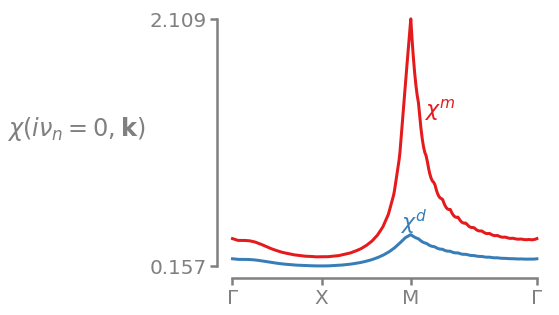

In [8]:
plot_chi(chi_m_wk, chi_d_wk)

## 2. Construct the particle-particle vertex in RPA

Now we have all the ingredients to build the particle-particle vertex in the RPA limit. In this example we limit us to the singlet particle-particle vertex for a symmetry constraint calculation of the Eliashberg equation.

\begin{align}
\Gamma^{\mathrm{singlet}}(i\omega_n, \mathbf{q})
=
3\Phi^{\mathrm{m}}(i\omega_n, \mathbf{q}) - 
3\Phi^{\mathrm{d}}(i\omega_n, \mathbf{q})
+
\frac{1}{2}
U^{\mathrm{d}}
+
\frac{3}{2}
U^{\mathrm{m}}
\,
\end{align}

where

\begin{align}
\Phi^{\mathrm{d/m}}(i\omega_n, \mathbf{q})
=
U^{\mathrm{d/m}}
\chi^{\mathrm{d/m}}(i\omega_n, \mathbf{q})
U^{\mathrm{d/m}}
\,.
\end{align}



For the 1-band case $U^{\mathrm{d/m}}=U$ and we don't have to take correct orbital ording in the products into account, which simplifies everything. But for generality we will show the process which also works for multi-orbital systems, where we first construct the density/magentic reducible ladder vertex $\Phi^{\mathrm{d/m}}$ via `construct_phi_wk`.

In [9]:
from triqs_tprf.lattice import construct_phi_wk

phi_d_wk = construct_phi_wk(chi_d_wk, U)
phi_m_wk = construct_phi_wk(chi_m_wk, U)

And then construct the singlet particle-particle vertex via `construct_gamma_singlet_rpa`.

In [10]:
from triqs_tprf.eliashberg import construct_gamma_singlet_rpa

gamma_singlet = construct_gamma_singlet_rpa(U, U, phi_d_wk, phi_m_wk)

## 3. Construct the symmetrizing functions

By using the above $\Gamma$ we must enforce the allowed $SPOT$ symmetries of the superconducting gap $\Delta$.
Our 1-band model is by default even in orbital symmetry and by using the singlet $\Gamma$ we are fixing the spin symmetry to odd. We are therefore left with two physical symmetry combinations.

| Spin | Parity (Momentum) | Orbital | Time (Frequency) |
|:----:|:-----------------:|:-------:|:----------------:|
|  odd |        even       |   even  |       even       |
|  odd |        odd        |   even  |        odd       |

We will solve for them individually, by constructing a symmetrizing function for each of them.
We do this by taking `enforce_symmetry` and using `functools.partial` to specifiy the symmetries that we want.

### Frequency: Even, Momentum: Even

In [11]:
import functools
from triqs_tprf.symmetries import enforce_symmetry

variables = ["frequency", "momentum"]
symmetries = ["even", "even"]

symmetrize_freq_even_mom_even = functools.partial(enforce_symmetry, variables=variables, symmetries=symmetries)

### Frequency: Odd, Momentum: Odd

In [12]:
symmetries = ["odd", "odd"]

symmetrize_freq_odd_mom_odd = functools.partial(enforce_symmetry, variables=variables, symmetries=symmetries)

## 4. Solve the linearized Eliashberg equation

Now we have everything that we need to solve the linearized Eliashberg equation. 
We call the `solve_eliashberg` function with each of our `symmetrize_fct`s and solve for the first leading eigenvalue, gap pair (`k=1`).

In [13]:
from triqs_tprf.eliashberg import solve_eliashberg

lambdas_freq_even_mom_even, deltas_freq_even_mom_even = solve_eliashberg(gamma_singlet, g0_wk, symmetrize_fct=symmetrize_freq_even_mom_even, k=1)
lambdas_freq_odd_mom_odd, deltas_freq_odd_mom_odd = solve_eliashberg(gamma_singlet, g0_wk, symmetrize_fct=symmetrize_freq_odd_mom_odd, k=1)

Plotting them shows that all symmetries are correct and that the gap with even frequency and odd momentum has the higher $\lambda$ and is therefore leading.

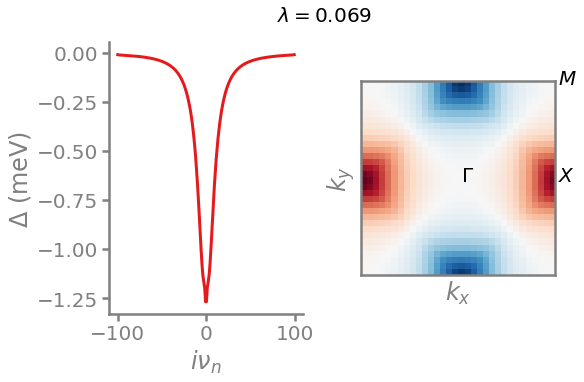

In [14]:
plot_delta(deltas_freq_even_mom_even[0], lambdas_freq_even_mom_even[0])

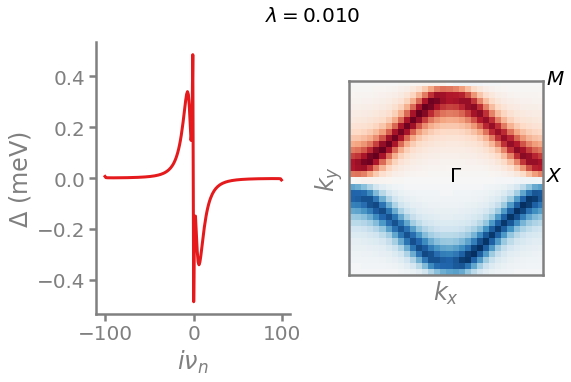

In [15]:
plot_delta(deltas_freq_odd_mom_odd[0], lambdas_freq_odd_mom_odd[0])

---